In [1]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import random

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 16

In [4]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [5]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [6]:
#train_ids = train_ids[:batch_size*10]#*100
#test_ids = test_ids[:batch_size*20]

In [7]:
len(train_ids), len(test_ids)

(762, 182)

In [8]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask


In [9]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [10]:
for images, masks in train_loader:
    print(images[0].shape)
    print(images[0])
    break

torch.Size([128, 128, 3])
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 4],
         [0, 0, 5],
         [0, 0, 5]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 4],
         [0, 0, 4],
         [0, 0, 4]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 2],
         [0, 0, 2],
         [0, 0, 2]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 1, 2],
         [0, 1, 2]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 1, 2],
         [0, 1, 2]]], dtype=torch.uint8)


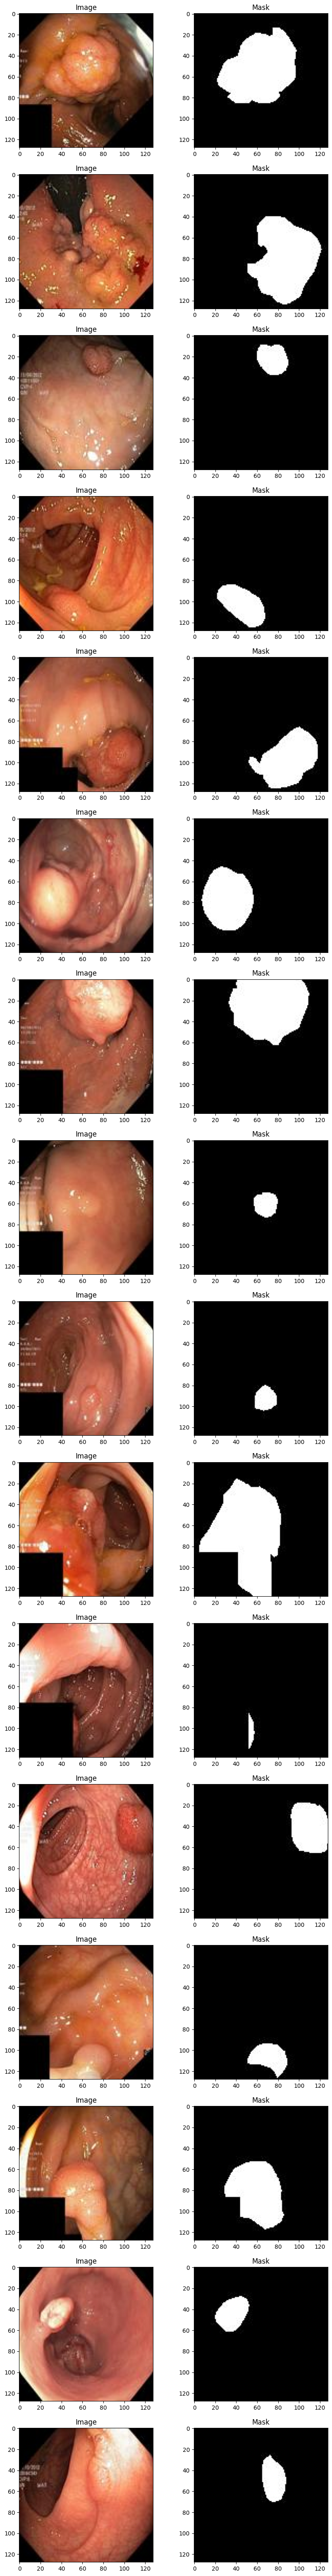

In [11]:
# plot the images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(masks[i], cmap='gray')
        axs[i, 1].set_title("Mask")
    plt.show()
# Get a batch of images and masks
for images, masks in train_loader:
    plot_images_and_masks(images, masks)
    break

In [12]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final Convolution
        self.final_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(torch.nn.functional.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(torch.nn.functional.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(torch.nn.functional.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc4, kernel_size=2))

        # Decoder
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        # Final output
        return self.final_conv(dec1)
    
# Instantiate the model
model = UNet()
# move model to device
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cuda:0


In [13]:
# test model with a random input
#x = torch.randn(512).to(device)
x = torch.rand(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[[[0.0837, 0.0891, 0.0848,  ..., 0.0857, 0.0849, 0.0874],
          [0.0800, 0.0870, 0.0924,  ..., 0.0892, 0.0864, 0.0883],
          [0.0798, 0.0849, 0.0894,  ..., 0.0888, 0.0908, 0.0898],
          ...,
          [0.0829, 0.0893, 0.0908,  ..., 0.0924, 0.0905, 0.0896],
          [0.0832, 0.0892, 0.0837,  ..., 0.0899, 0.0925, 0.0858],
          [0.0766, 0.0814, 0.0827,  ..., 0.0819, 0.0843, 0.0839]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


In [14]:
y.shape

torch.Size([1, 1, 128, 128])

In [15]:
# test model with the first image from the train dataset
for i, (image, mask) in enumerate(train_loader):
    image = image.to(device).permute(0, 3, 1, 2)/255
    y = model(image)
    print(y.int())
    break

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

In [16]:
image[0].shape

torch.Size([3, 128, 128])

In [17]:
mask[0].shape

torch.Size([128, 128])

In [18]:
mask[0].max(), mask[0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [19]:
# train u network, use IOU
def iou_loss(pred, target, smooth=0):
    intersection = torch.minimum(pred, target).sum(dim=(1, 2))
    union = torch.maximum(pred, target).sum(dim=(1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou.mean()

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, masks in train_loader:
        images = (images.permute(0, 3, 1, 2)/255).to(device)
        masks = masks.unsqueeze(1).to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        #outputs = torch.sigmoid(outputs)  # Sigmoid activation for binary segmentation
        # Compute loss
        loss = iou_loss(outputs, masks)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

Epoch [1/100], Loss: 0.8784
Epoch [2/100], Loss: 0.8275
Epoch [3/100], Loss: 0.8181
Epoch [4/100], Loss: 0.8129
Epoch [5/100], Loss: 0.8058
Epoch [6/100], Loss: 0.8036
Epoch [7/100], Loss: 0.7994
Epoch [8/100], Loss: 0.7947
Epoch [9/100], Loss: 0.7933
Epoch [10/100], Loss: 0.7926
Epoch [11/100], Loss: 0.7879
Epoch [12/100], Loss: 0.7832
Epoch [13/100], Loss: 0.7808
Epoch [14/100], Loss: 0.7748
Epoch [15/100], Loss: 0.7725
Epoch [16/100], Loss: 0.7704
Epoch [17/100], Loss: 0.7662
Epoch [18/100], Loss: 0.7646
Epoch [19/100], Loss: 0.7597
Epoch [20/100], Loss: 0.7585
Epoch [21/100], Loss: 0.7543
Epoch [22/100], Loss: 0.7494
Epoch [23/100], Loss: 0.7474
Epoch [24/100], Loss: 0.7472
Epoch [25/100], Loss: 0.7412
Epoch [26/100], Loss: 0.7379
Epoch [27/100], Loss: 0.7384
Epoch [28/100], Loss: 0.7336
Epoch [29/100], Loss: 0.7301
Epoch [30/100], Loss: 0.7259
Epoch [31/100], Loss: 0.7208
Epoch [32/100], Loss: 0.7184
Epoch [33/100], Loss: 0.7172
Epoch [34/100], Loss: 0.7201
Epoch [35/100], Loss: 0

In [20]:
torch.cuda.empty_cache()

In [21]:
# remove from the device all but except the models
model.cpu()
device = "cpu"

In [22]:
# test the model on the test dataset and calculate the mean iou
model.eval()
ious = torch.zeros(len(test_loader)).to(device)
masks_list = []
ious_list = []
images_list_mem = []
target_masks_list = []

for i, (images, target_masks) in enumerate(test_loader):
    if i < 36:
        images_list_mem.append(images)
        target_masks_list.append(target_masks)
    
    target_masks = target_masks.detach().numpy()
    images = images.to(device).permute(0, 3, 1, 2) / 255
    masks = model(images)
    if i < 36:
        masks_list.append(masks)

    masks = masks.detach().numpy()
    # 1. Compute Intersection over Union
    intersection = np.minimum(masks, target_masks).sum()
    union = np.maximum(masks, target_masks).sum()
    iou = intersection / union
    
    ious_list.append(iou)

In [23]:
# calculate the mean iou and the std of the ious
ious = torch.tensor(ious_list)
ious.mean(), ious.std(), ious.max(), ious.min(), ious.median()

(tensor(0.3883, dtype=torch.float64),
 tensor(0.2067, dtype=torch.float64),
 tensor(0.8461, dtype=torch.float64),
 tensor(3.8958e-05, dtype=torch.float64),
 tensor(0.3824, dtype=torch.float64))

In [24]:
masks_list[0][0].shape

torch.Size([1, 128, 128])

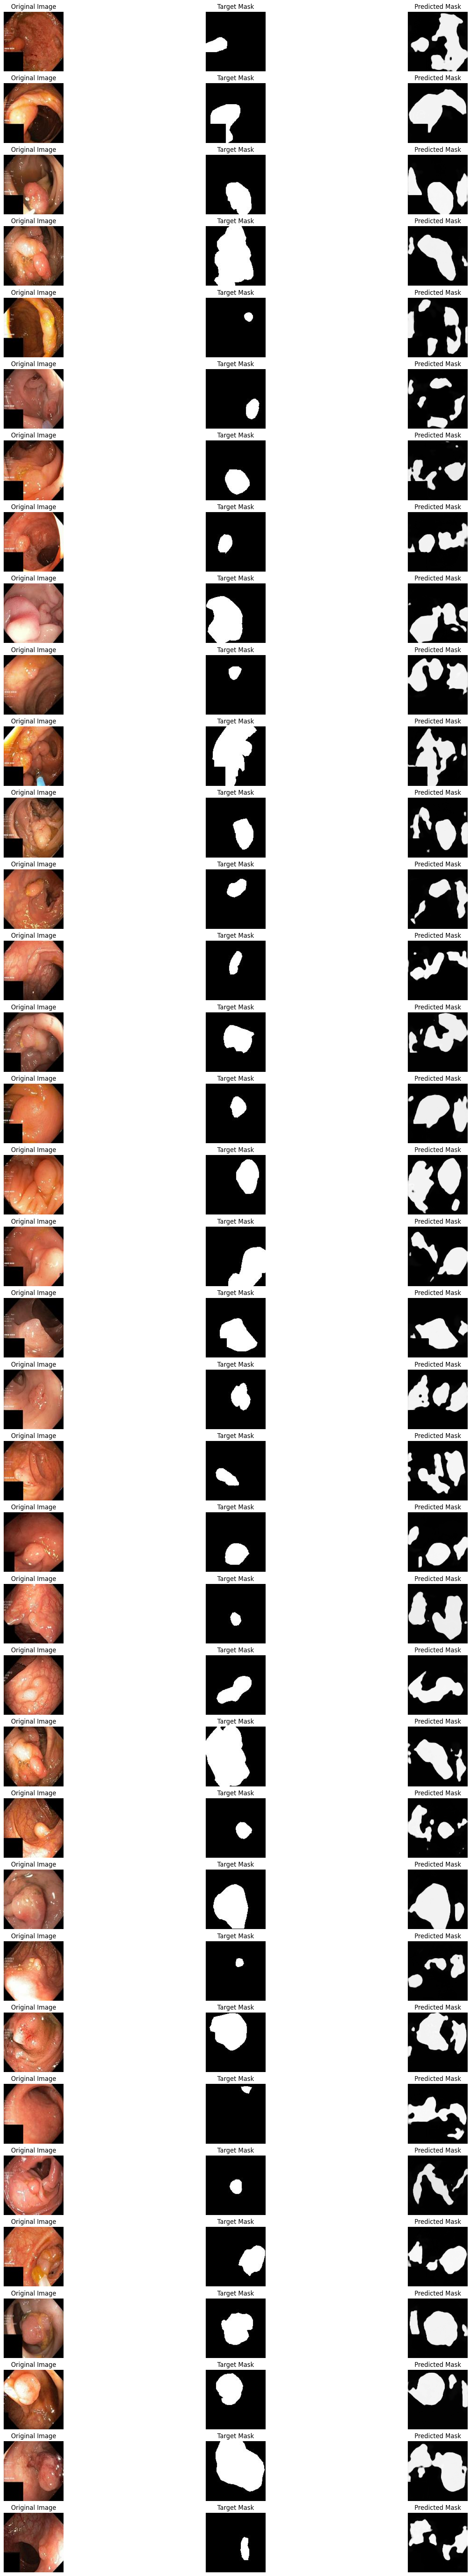

In [25]:
#visualize original images, prompt points, target masks and predicted masks of the test images
plt.figure(figsize=(20, 90))
# add title to the plot
for i in range(36):
    plt.subplot(36, 3, 3 * i + 1)
    plt.imshow(images_list_mem[i].squeeze(0))
    plt.title(f"Original Image")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 2)
    plt.imshow(target_masks_list[i][0], cmap='gray')
    plt.title("Target Mask")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 3)
    plt.imshow(masks_list[i][0][0].detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
plt.show()

In [26]:
# save the model
torch.save(model.state_dict(), "base_line_segmentator.pth")